# 地方競馬（NAR）新規特徴量の可視化と性能分析 (14モデル)

フェーズ 9 で導入した高度な特徴量（相対指標、状況適性）の中身を詳しく分析し、モデルの動作原理とデータの分布を確認します。

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

# プロジェクトのsrcディレクトリをパスに追加
src_path = os.path.abspath(os.path.join(os.getcwd(), '../../src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from nar.loader import NarDataLoader
from nar.features import NarFeatureGenerator

%matplotlib inline
sns.set(font='IPAexGothic', style='whitegrid')

In [2]:
loader = NarDataLoader()
raw_df = loader.load(limit=100000, region='south_kanto')

generator = NarFeatureGenerator(history_windows=[1, 2, 3, 4, 5])
df = generator.generate_features(raw_df)

df = df.dropna(subset=['rank']).copy()
df['date'] = pd.to_datetime(df['date'])

print(f'データ件数: {len(df)}')

重複データを削除しました: 100000 -> 98004 件


データ件数: 25721


## 1. レース内相対指標の分布分析

スピード指数偏差値 (`weighted_si_momentum_zscore`) や相対順位が、実際の着順とどのように関連しているかを確認します。

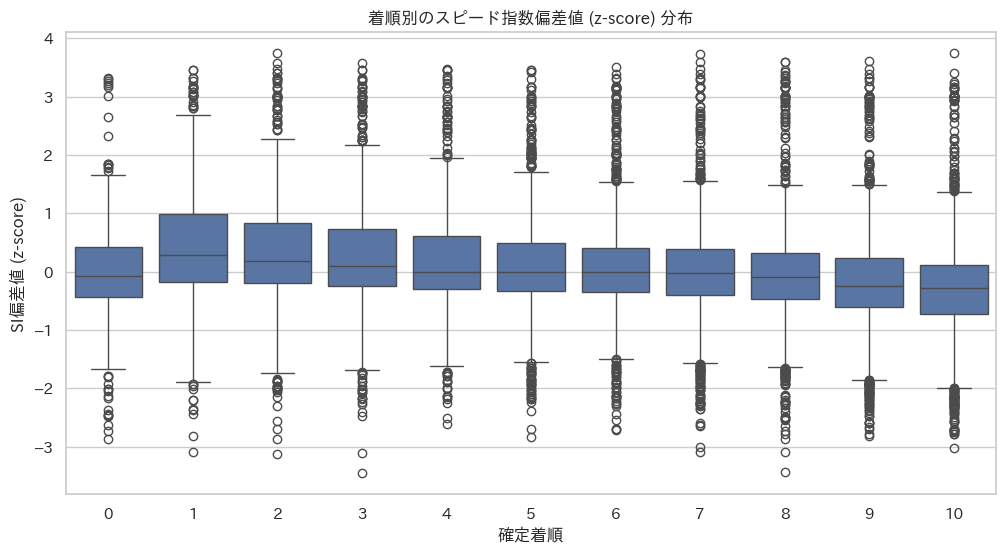

考察: 着順が良い（小さい）ほど、z-scoreが高い（右肩下がり）傾向があれば、相対指標が強力な予測因子であることを示します。


In [3]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='rank', y='weighted_si_momentum_zscore', data=df[df['rank'] <= 10])
plt.title('着順別のスピード指数偏差値 (z-score) 分布')
plt.xlabel('確定着順')
plt.ylabel('SI偏差値 (z-score)')
plt.show()

print('考察: 着順が良い（小さい）ほど、z-scoreが高い（右肩下がり）傾向があれば、相対指標が強力な予測因子であることを示します。')

## 2. 状況適性の分析

馬場状態別成績 (`horse_state_place_rate`) や季節・ナイターが的中率に与える影響を確認します。

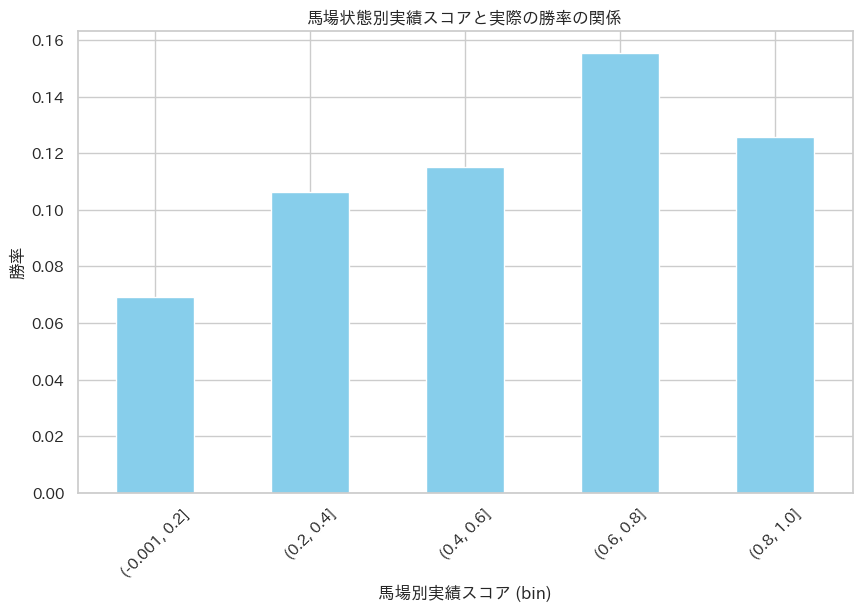

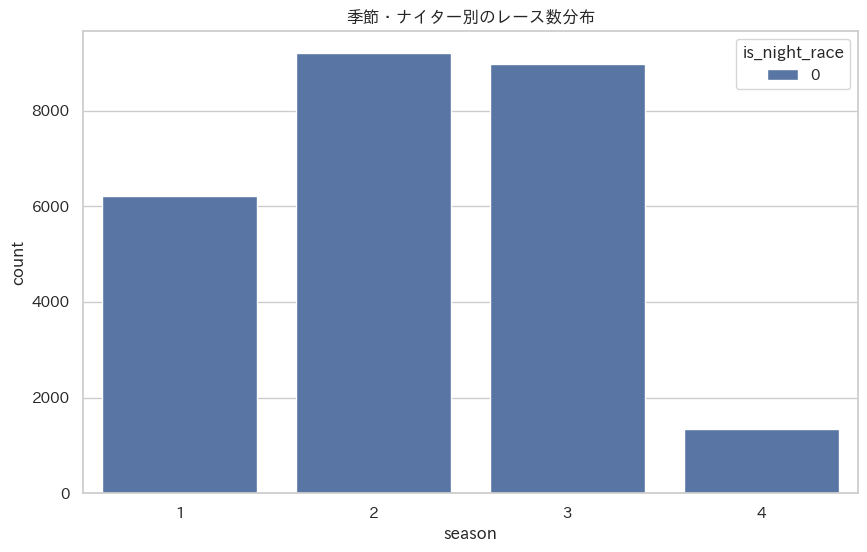

In [4]:
df['state_place_rate_bin'] = pd.cut(df['horse_state_place_rate'], bins=5)
plt.figure(figsize=(10, 6))
df.groupby('state_place_rate_bin', observed=True)['rank'].apply(lambda x: (x==1).mean()).plot(kind='bar', color='skyblue')
plt.title('馬場状態別実績スコアと実際の勝率の関係')
plt.xlabel('馬場別実績スコア (bin)')
plt.ylabel('勝率')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='season', hue='is_night_race', data=df)
plt.title('季節・ナイター別のレース数分布')
plt.show()

## 3. 人間系の勢いバイアス分析

`trainer_momentum_bias` (直近30日の上振れ) が結果にどう影響するかを確認します。

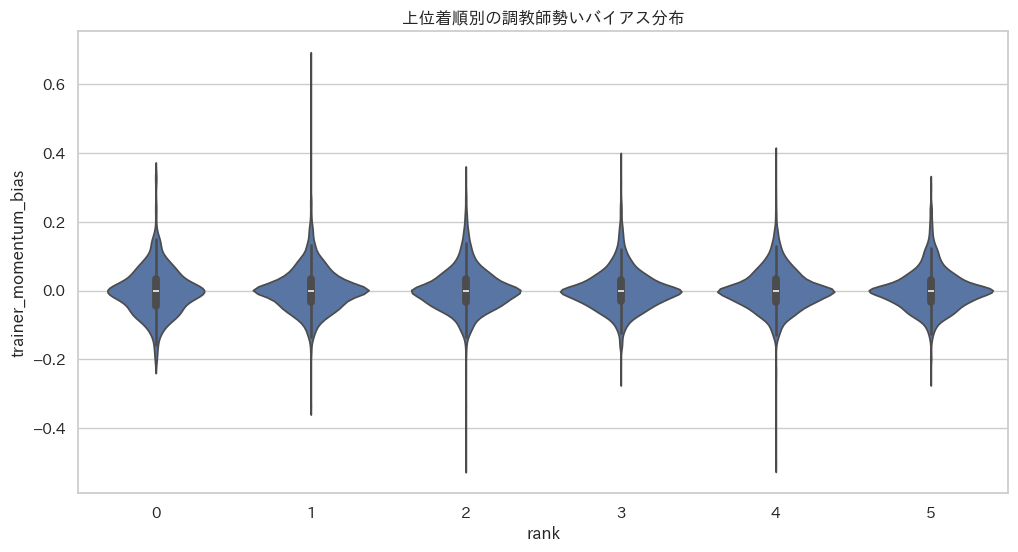

In [5]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='rank', y='trainer_momentum_bias', data=df[df['rank'] <= 5])
plt.title('上位着順別の調教師勢いバイアス分布')
plt.show()